데이터 불러오기

In [ ]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import random
from torchvision import datasets
import torchvision.models as models
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import os
import glob
from collections import Counter

In [ ]:
resnet34 = models.resnet34(pretrained=True)
model = resnet34.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 61.0MB/s]


In [ ]:
# 무작위 시드 설정과 배치 크기 설정
batch_size  = 16
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

In [ ]:
# 데이터셋 불러오기
data_path = '/content/drive/MyDrive/lung_data'
lung_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))

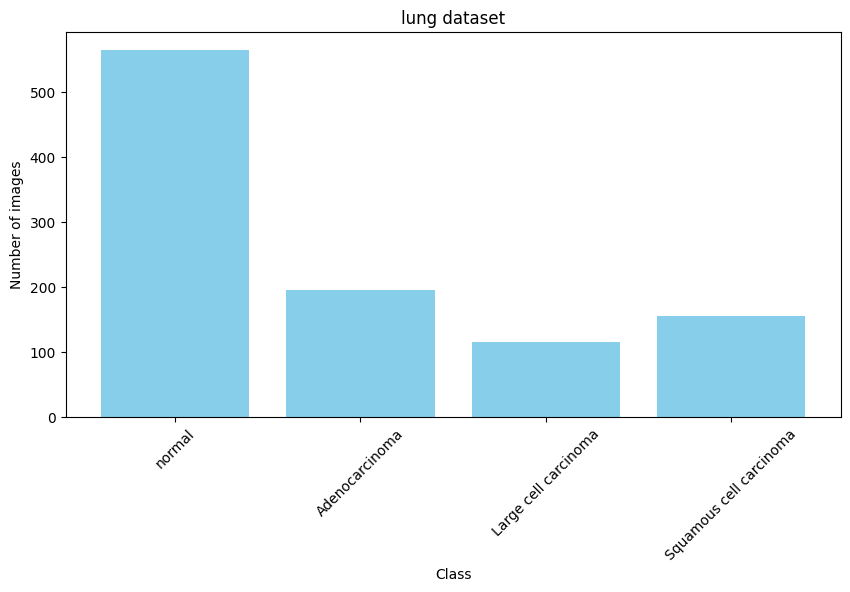

In [ ]:
# 클래스 이름 매핑 딕셔너리
class_name_mapping = {
    'A': 'normal',
    'B': 'Adenocarcinoma',
    'C': 'Large cell carcinoma',
    'D': 'Squamous cell carcinoma'
}

# 클래스별 이미지 개수 계산
class_counts = Counter([lung_dataset.classes[label] for _, label in lung_dataset])

# 클래스 이름 매핑 적용
mapped_class_counts = {class_name_mapping[cls]: count for cls, count in class_counts.items()}

# 클래스별 개수를 시각화
class_names = list(mapped_class_counts.keys())
counts = list(mapped_class_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('lung dataset')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 데이터 나누기
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split

train_size = int(0.8 * len(lung_dataset))
valid_size = int(0.1 * len(lung_dataset))
test_size = len(lung_dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(lung_dataset, [train_size, valid_size, test_size])

# 데이터로더를 생성할 때 사용할 수 있도록 딕셔너리에 저장
datasets = {'train': train_dataset, 'valid': valid_dataset, 'test': test_dataset}

In [ ]:
train_dataset

In [ ]:
# data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=2)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=2)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=2)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  train-valid-test : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 16,  train-valid-test : 52 / 7 / 7


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


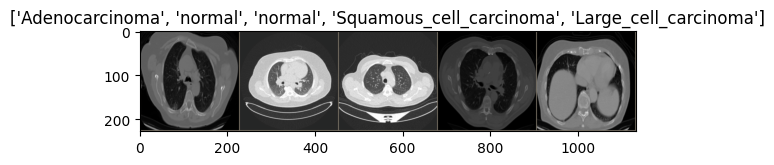

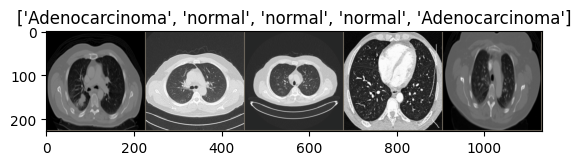

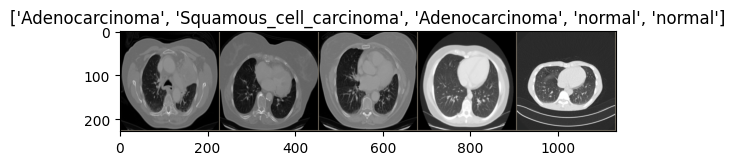

In [ ]:
# 데이터 체크
def showdata(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # numpy로 배열한 후에 (높이, 너비, 채널)을 (채널, 높이, 너비)로 변경
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # 정규화를 반전시켜 원본 이미지의 형태로 되돌리는 작업
    inp = np.clip(inp, 0, 1) # 픽셀 값이 0보다 작으면 0으로, 1보다 크면 1로 설정
    plt.imshow(inp)
    if title is not None: # title이 없다면 추가
        plt.title(title)
    plt.pause(0.001)  # 플롯을 갱신한 후 잠시 멈춰서 사용자가 플롯을 볼 수 있도록

num_show_img = 5 # 5개씩 출력

class_names = {
    "0": "normal",
    "1": "Adenocarcinoma",
    "2": "Large_cell_carcinoma",
    "3": "Squamous_cell_carcinoma"
}

# train check
inputs, classes = next(iter(dataloaders['train'])) # 값을 차례대로 반환하는 iterator 생성
out = torchvision.utils.make_grid(inputs[:num_show_img]) # 이미지들을 행렬(matrix) 형태로 배치하여 한 번에 시각화할 수 있도록
showdata(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])
showdata(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])
showdata(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(),
                         lr = 0.01,
                         momentum=0.9,  # 모멘텀은 SGD의 업데이트 방식 중 하나로, 진동이나 불안정성을 줄이기 위해 사용
                         weight_decay=0.0005) # 과적합을 방지하기 위해 가중치 감소를 적용

lmbda = lambda epoch: 0.98739 # epoch마다 학습률을 조절
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda) # 학습률을 동적으로 조절하기 위해 사용되는 스케줄러를 정의

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0  # 최고 정확도를 나타내는 변수를 초기화
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], [] # 훈련 손실, 훈련 정확도, 검증 손실, 검증 정확도를 저장할 빈 리스트를 초기화

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10) # epoch의 시작을 표시하기 위해 하이픈('-')을 10번 출력

        for phase in ['train', 'valid']:
            if phase == 'train': # 현재 모드가 train인 경우 훈련
                model.train()
            else:                # 아닌 경우 평가
                model.eval()

            running_loss, running_corrects, num_cnt = 0.0, 0, 0 # 현재 실행 중인 손실, 현재 실행 중인 올바른 예측의 수, 현재 실행 중인 샘플의 수

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # 기울기를 0으로 설정

                with torch.set_grad_enabled(phase == 'train'):  # 'train' 모드일 때만 기울기를 계산하도록 설정
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # 모델의 출력에서 가장 큰 값의 인덱스를 찾아 예측값을 계산하고  모델의 출력 중 가장 높은 확률을 가진 클래스를 예측하는 데 사용
                    loss = criterion(outputs, labels) # 모델의 출력과 실제 레이블 사이의 손실을 계산

                    if phase == 'train':
                        loss.backward() # 손실에 대한 역전파를 수행
                        optimizer.step()  # 역전파로 계산된 기울기를 사용하여 모델의 매개변수를 조정하여 손실을 최소화하는 방향으로 모델을 학습

                running_loss += loss.item() * inputs.size(0) # loss.item()은 현재 배치의 손실 값, inputs.size(0)은 현재 배치의 데이터 개수인데 이를 곱하여 배치의 전체 손실을 계산하고, 이를 running_loss에 누적
                running_corrects += torch.sum(preds == labels.data) # preds == labels.data는 예측값과 실제 레이블이 일치하는지에 대한 불리언 마스크(mask)를 생성하고, torch.sum()을 사용하여 이를 합산합니다.
                num_cnt += len(labels) # 현재 배치의 샘플 수를 num_cnt에 누적해 전체 데이터셋의 크기 추적
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)  # 평균 손실
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100) # 평균 정확도

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

                filename = '/content/drive/MyDrive/model_{epoch}.pth'.format(epoch=epoch)
                torch.save(model.state_dict(), filename)
                print('model saved')

    time_elapsed = time.time() - since   # 시작 시간(since)으로부터 현재까지의 경과 시간을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) # 전체 훈련 시간을 표시
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc)) # 최고 검증 정확도와 그때의 에포크 번호를 출력

    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 1.24 Acc: 69.3
valid Loss: 0.57 Acc: 73.5
==> best model saved - 0 / 73.5
model saved
Epoch 1/99
----------
train Loss: 0.47 Acc: 80.6
valid Loss: 0.54 Acc: 90.2
==> best model saved - 1 / 90.2
model saved
Epoch 2/99
----------
train Loss: 0.30 Acc: 88.5
valid Loss: 0.50 Acc: 80.4
Epoch 3/99
----------
train Loss: 0.26 Acc: 91.5
valid Loss: 0.55 Acc: 83.3
Epoch 4/99
----------
train Loss: 0.15 Acc: 94.4
valid Loss: 0.43 Acc: 83.3
Epoch 5/99
----------
train Loss: 0.10 Acc: 96.5
valid Loss: 0.21 Acc: 92.2
==> best model saved - 5 / 92.2
model saved
Epoch 6/99
----------
train Loss: 0.11 Acc: 96.0
valid Loss: 0.40 Acc: 92.2
Epoch 7/99
----------
train Loss: 0.06 Acc: 97.7
valid Loss: 0.46 Acc: 89.2
Epoch 8/99
----------
train Loss: 0.05 Acc: 98.3
valid Loss: 0.54 Acc: 89.2
Epoch 9/99
----------
train Loss: 0.06 Acc: 98.4
valid Loss: 0.35 Acc: 89.2
Epoch 10/99
----------
train Loss: 0.02 Acc: 99.4
valid Loss: 0.30 Acc: 95.1
==> best model saved - 10 / 95.

best model : 81 - 98 / 0.2


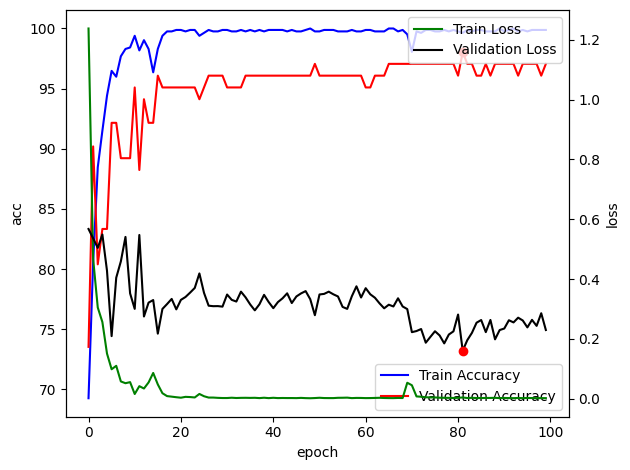

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-', label='Train Accuracy')
ax1.plot(valid_acc, 'r-', label='Validation Accuracy')
plt.plot(best_idx, valid_acc[best_idx], 'ro')

ax1.set_xlabel('epoch')

ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-', label='Train Loss')
ax2.plot(valid_loss, 'k-', label='Validation Loss')
plt.plot(best_idx, valid_loss[best_idx], 'ro')

ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')
ax2.legend()

fig.tight_layout() # 그래프의 레이아웃을 조정
plt.show()

In [ ]:
import torch
import torchvision.models as models
from sklearn.metrics import roc_auc_score

model_numbers = [0, 1, 5, 10, 15, 49, 81]

for i in model_numbers :

  model = models.resnet34()
  model.load_state_dict(torch.load('/content/drive/MyDrive/model_{number}.pth'.format(number=i)))

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  model.eval()


  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in dataloaders['test']:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  # 정확도 계산
  accuracy = 100 * correct / total

  print('Model {} - Validation accuracy: {:.2f}%'.format(i, accuracy))

Model 0 - Validation accuracy: 75.00%
Model 1 - Validation accuracy: 84.62%
Model 5 - Validation accuracy: 89.42%
Model 10 - Validation accuracy: 94.23%
Model 15 - Validation accuracy: 92.31%
Model 49 - Validation accuracy: 94.23%
Model 81 - Validation accuracy: 95.19%


Model Number: 81, Image File: A-1.png, Predicted Label: 0


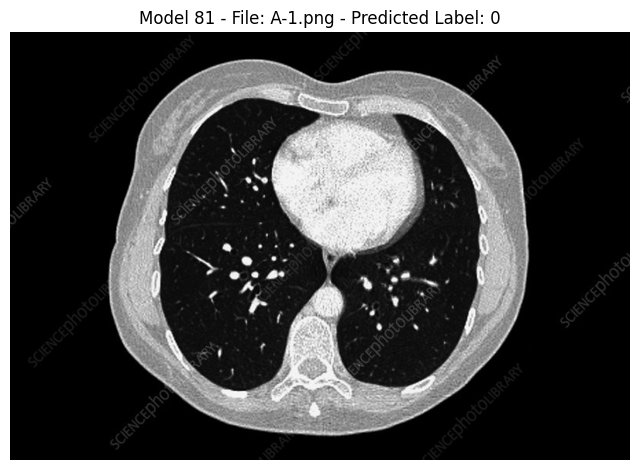

Model Number: 81, Image File: A-2.png, Predicted Label: 0


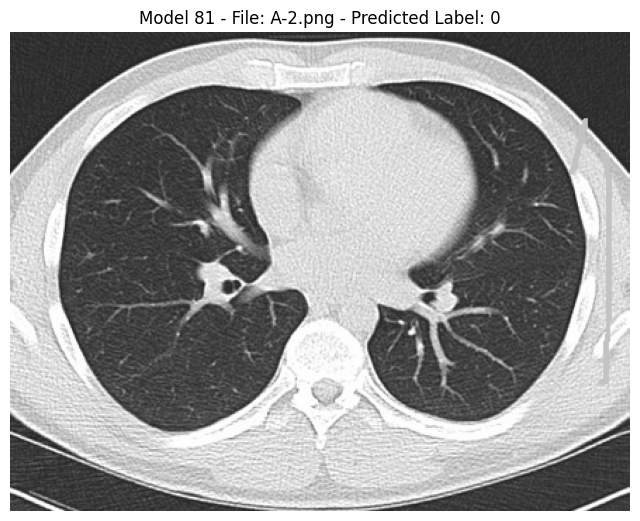

Model Number: 81, Image File: A-3.png, Predicted Label: 0


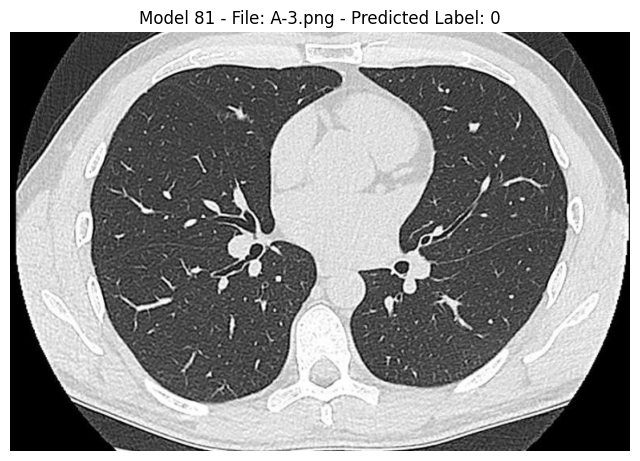

Model Number: 81, Image File: B-1.png, Predicted Label: 1


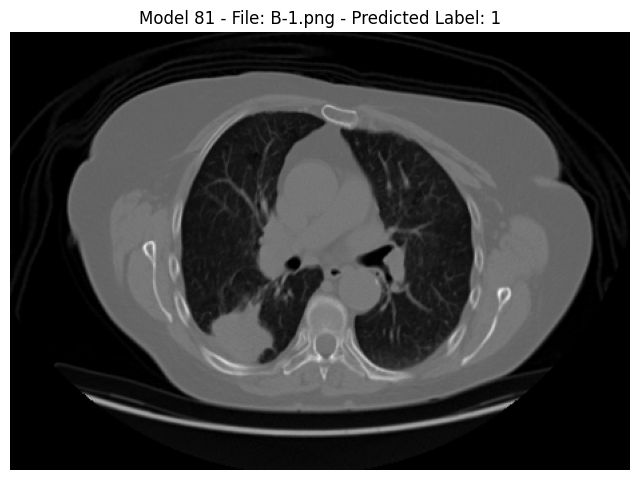

Model Number: 81, Image File: B-2.png, Predicted Label: 1


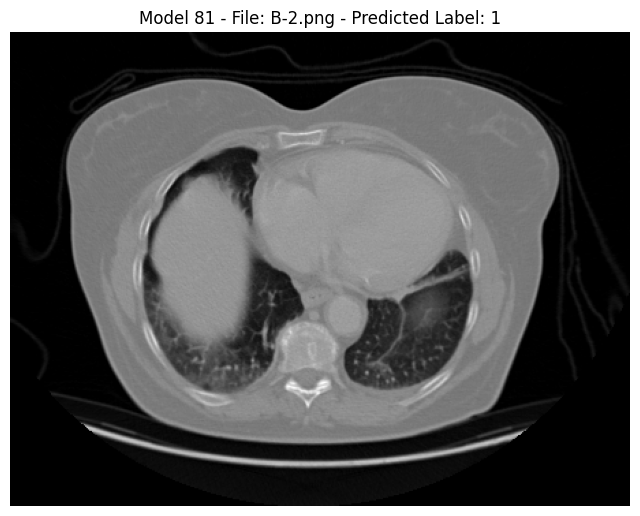

Model Number: 81, Image File: B-3.png, Predicted Label: 1


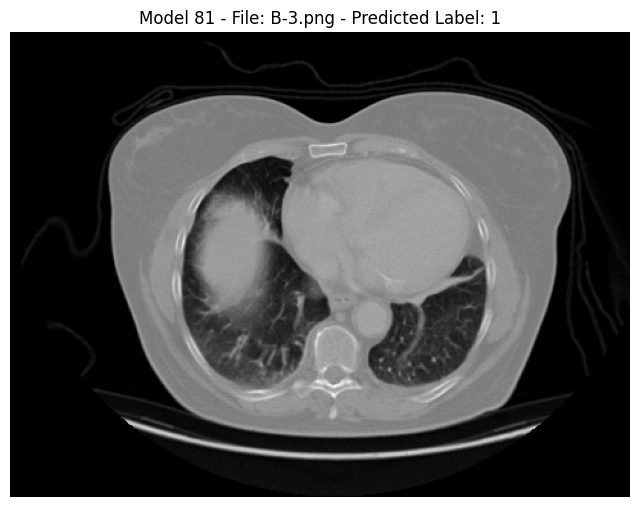

Model Number: 81, Image File: C-1.png, Predicted Label: 2


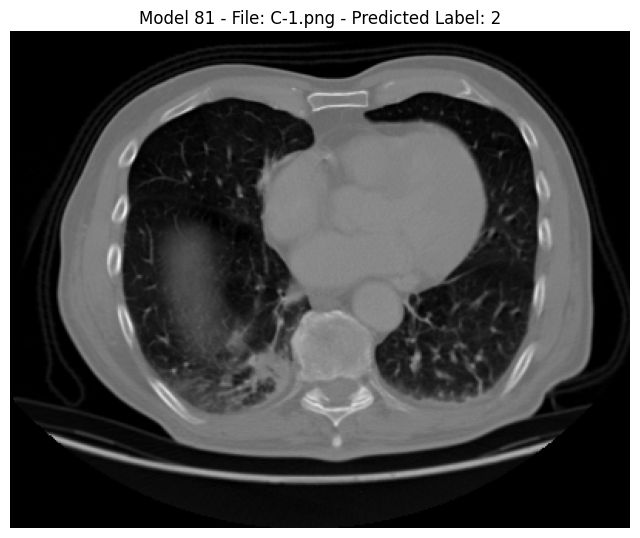

Model Number: 81, Image File: C-2.png, Predicted Label: 2


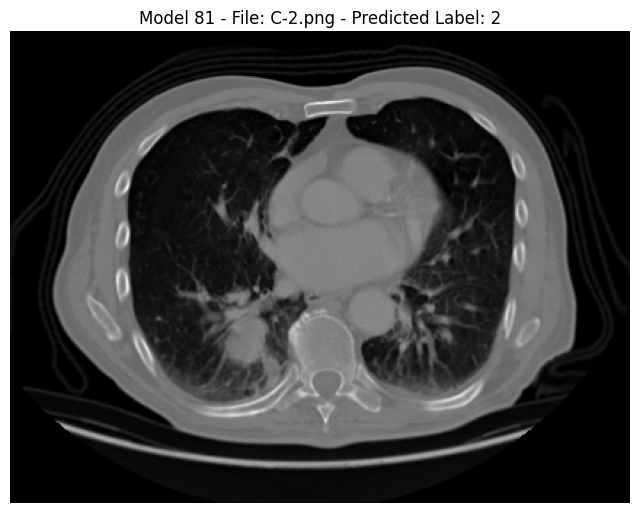

Model Number: 81, Image File: C-3.png, Predicted Label: 2


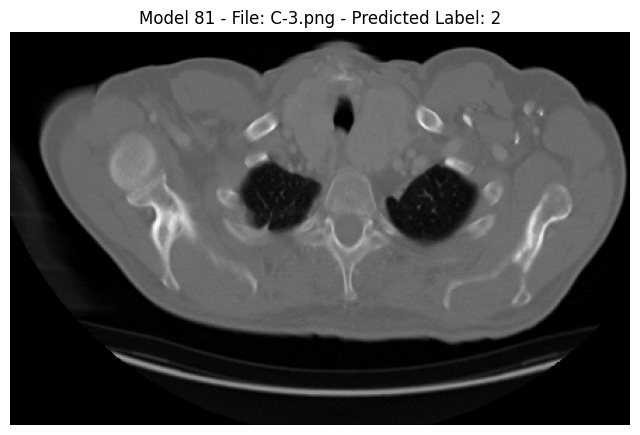

Model Number: 81, Image File: D-1.png, Predicted Label: 3


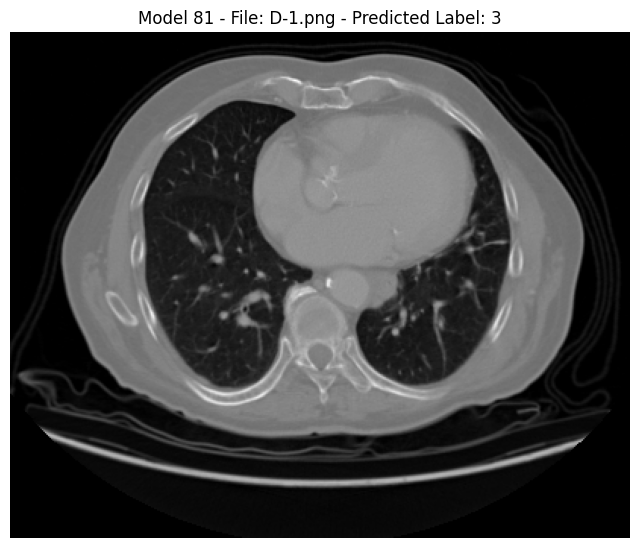

Model Number: 81, Image File: D-2.png, Predicted Label: 3


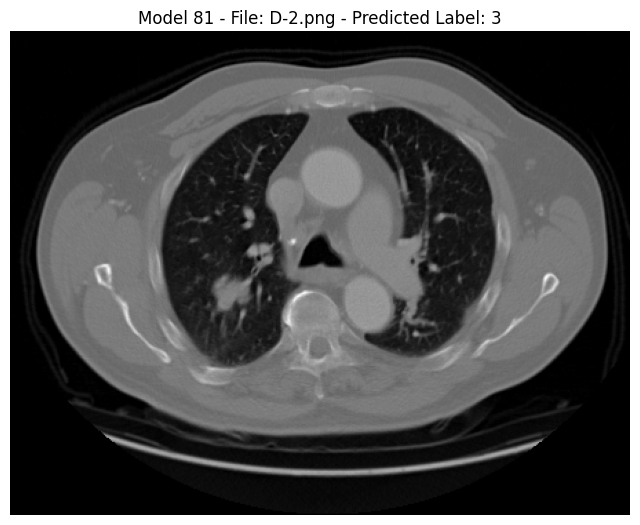

Model Number: 81, Image File: D-3.png, Predicted Label: 3


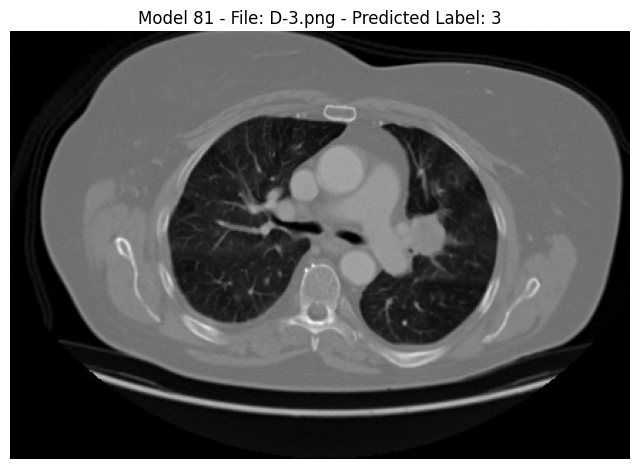

In [ ]:
import os
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import glob

# 이미지 전처리 파이프라인
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 이미지 불러오기 및 전처리
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # RGB로 변환
    image = transform(image).unsqueeze(0)  # 배치 차원 추가
    return image

# 시각화 함수
def visualize(image_path, model, device, model_number):
    # 이미지 로드 및 전처리
    image = load_image(image_path).to(device)

    # 모델 예측
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # 원본 이미지 로드 (시각화를 위해 전처리 안된 이미지 로드)
    original_image = Image.open(image_path).convert('RGB')

    file_name = os.path.basename(image_path)

    print(f'Model Number: {model_number}, Image File: {file_name}, Predicted Label: {predicted.item()}')

    # 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.title(f'Model {model_number} - File: {file_name} - Predicted Label: {predicted.item()}')
    plt.axis('off')
    plt.show()

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = models.resnet34()
model.load_state_dict(torch.load('/content/drive/MyDrive/model_81.pth'))
model.to(device)

# 테스트 이미지 경로 패턴
test_image_paths = glob.glob('/content/drive/MyDrive/test/*.png')

for test_image_path in test_image_paths:
    # 시각화 함수 호출
    visualize(test_image_path, model, device, i)